In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Pasta do projeto
%cd /content/drive/MyDrive/Git colab/TOPIA T1/Geracao-texto-lstm

/content/drive/MyDrive/Git colab/TOPIA T1/Geracao-texto-lstm


#Gerador de Letras de Samba (LSTM Bidirecional)

In [15]:
#Bibliotecas:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
from collections import Counter
import re
import random
import re
import os

In [4]:
#CONSTANTES
MODELO = 'modelo_baseline_melhor.pth'

SEQ_LENGTH = 20
VOCAB_SIZE = 5000
BATCH_SIZE = 128
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
NUM_LAYERS = 2
LEARNING_RATE = 0.0005
NUM_EPOCHS = 10 #Só para ser mais rapido, o recomendado é 15 ou até mesmo 30
BIDIRECTIONAL = True
SEED = 42

In [5]:
#Classes

class TextoDataset(Dataset):
    def __init__(self, entrada, prevista):
        self.entrada = entrada
        self.prevista = prevista

    def __len__(self):
        return len(self.entrada)

    def __getitem__(self, idx):
        return self.entrada[idx], self.prevista[idx]

class GeradorTextoLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(GeradorTextoLSTM, self).__init__()
        self.num_directions = 2
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.5 if num_layers > 1 else 0,
            bidirectional=BIDIRECTIONAL
        )
        self.linear = nn.Linear(hidden_dim * self.num_directions, vocab_size)


    def forward (self, x, hidden=None):
        embedded = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embedded, hidden)

        h_fwd = h_n[-2,:,:]
        h_bwd = h_n[-1,:,:]

        ultima_saida = torch.cat([h_fwd, h_bwd], dim=1)
        output = self.linear(ultima_saida)

        return output, (h_n,c_n)

In [6]:
#Funções

def criagem_corpus ():
    #Criando um vetor corpus com as musicas encontradas no .txt extraido no site de musica.
    vet = []
    total = 0
    with open("corpus.txt","r",encoding="utf-8") as dados:
        for letra in dados:
            if len(letra) > 1: #não coletamos as linhas em branco no .txt
                vet.append(letra)

    #Info do corpus:
    print(f"Total de músicas: {len(vet)}")
    for i in range(0,len(vet)):
        total += len(vet[i].split())
    print(f"Total de palavras: {total}")
    print(f"Média de palavras por música: {(total/len(vet)):.2f}")

    return vet
def tokenizacao(vetor):

    #metodo de tokenização robusto! Customizada por Regex.
    completo_txt = " ".join(vetor).lower()
    #retiramos acentuação
    completo_txt = re.sub(r'[^\w\s]|_',' ',completo_txt)

    #Regex, caputra palavras com acento e numeros
    t = re.findall(r"[a-záàâãéêíóôõúç0-9]+", completo_txt)
    t = [w for w in t if len(w) > 1] #Remove caracteres de somente um caractere.Note que caracteres como artigo não apareceram na musica, pode retirar essa linha caso queira.

    return t
def mapeamento(size):

    #pad = preencher sequências | sos = start of sequence | unk = unknown, ou seja palavras raras.
    v = {"<pad>":0,"<sos>":1,"<unk>":2}

    #adiciona-mos as palavras mais frequentes
    v.update({
        palavra: i + 3
        for i, (palavra,_) in enumerate (size.most_common(VOCAB_SIZE - 3))})

    u = {id: palavra for palavra, id in v.items()}

    return v, u
def preparacao_dados(t_id):
    #criação de sequencias de treinamento (Sliding Window)
        #transforma a lista de todos os IDs em pares Entrada/Saída (e,s)
            #entrada = sequências | saída = próxima palavra

    e = []; s = []
    for i in range(0,len(t_id)-SEQ_LENGTH):
        seq_in = t_id[i:i+SEQ_LENGTH]
        seq_out = t_id[i+SEQ_LENGTH]

        e.append(seq_in);s.append(seq_out)
    return e,s
def preparacao_dados_tamanho(e):
    #Treino(80) - Validação(10) - Teste(10)
    # 0.8 = evitar vazamento
    tamanho_treino = int(len(e)*0.8)
    tamanho_val = int(0.1 * len(e)) + tamanho_treino
    return [tamanho_treino,tamanho_val]
def treinar_modelo(mod,d_treino,d_val,crit,opt,n_epocas):
    print("\nIniciando treinamento do Baseline! ")

    melhor_loss_val = float("inf")

    hist_treino =[];hist_val = []

    for epocas in range(n_epocas):
        # 1ª - Fase de Treinamento:
        mod.train() #ativa dropout + ajuste de pesos.
        t_loss_treino = 0

        for e_batch, s_batch in d_treino:
            e_batch, s_batch = e_batch.to(device), s_batch.to(device)
            opt.zero_grad()
            out, _ = mod(e_batch)
            loss = crit(out,s_batch)
            loss.backward()

            #Clipping de Gradiente -> previne a 'explosao' de gradientes em RNN
            nn.utils.clip_grad_norm_(mod.parameters(),max_norm= 1.0)
            opt.step()
            t_loss_treino += loss.item() * e_batch.size(0)

        #2ª - Fase de Validacao:
        mod.eval() #desativa dropout
        t_loss_val = 0

        with torch.no_grad(): #Economia de recursos: desativa o cáluco de gradiente
            for e_batch_val, s_batch_val in d_val:
                e_batch_val, s_batch_val = e_batch_val.to(device), s_batch_val.to(device)
                output_val, _ = mod(e_batch_val)
                loss_val = crit(output_val,s_batch_val)
                t_loss_val += loss_val.item() * e_batch_val.size(0)

        m_loss_treino = t_loss_treino / len(d_treino.dataset)
        m_loss_val = t_loss_val/len(d_val.dataset)

        hist_treino.append(m_loss_treino)
        hist_val.append(m_loss_val)

        print(f"Época {epocas+1}/{n_epocas} \n| Loss Treino: {m_loss_treino:.4f} \n| Loss Val: {m_loss_val:.4f}")



        #3ª - Salvamento do Modelo

        ''' - Usando m_loss_val(Loss de Validação) é o mais correto, sendo mais robosto contra o overfitting
            - Usando m_loss_treino(Loss de Treino) é o que nos entrega textos com melhor qualidade, mas com grande overfitting, ou seja, ganhamos em qualidade mas perdemos no nível de generalização.
        '''

        if m_loss_val < melhor_loss_val:
            melhor_loss_val = m_loss_val
            torch.save(mod.state_dict(), 'modelo_baseline_melhor.pth')

            print(">>> Modelo salvo (Melhor Loss de Validação) <<<")
    return hist_treino, hist_val
def gerar_texto(m,start_txt,num_word_gen,temp,wti,itw,seq_length):
    m.eval() #desativa dropout: geração de txt + estavel.
    tokens_start = re.findall(r'\b\w+\b', start_txt.lower())

    # 1ª - Padding/Trucanmento da semente para ter SEQ_LENGHT exato
    if len(tokens_start) < seq_length:
        # add <pad> se for muito curta
        input_tokens = [wti["<pad>"]] * (seq_length - len(tokens_start)) + [wti.get(t, wti["<unk>"]) for t in tokens_start]
    else:
        #trunca para os ultimos SEQ_LENGHT tokens se for muito longa.
        input_tokens = [wti.get(t, wti["<unk>"]) for t in tokens_start[-seq_length:]]

        #Converte para tensor e move para a GPU
    input_tensor = torch.LongTensor(input_tokens).unsqueeze(0).to(device)
    txt_gerado = list(tokens_start)
    hidden = None

    with torch.no_grad(): #desativa o calculo de gradientes
        for _ in range(num_word_gen):
            output, _ = m(input_tensor)

            #2ª - Amostragem por Temperatura(T), ou seja: ajuste de "criativade" da distrubicao
            output_dist = output.squeeze().div(temp).exp()
            next_word_id = torch.multinomial(output_dist,1).item() # escolhe prox palavra

            #3ª - Roll Over: remove o primeiro token e adiciona o novo ID gerado
            input_tokens.pop(0)
            input_tokens.append(next_word_id)
            input_tensor = torch.LongTensor(input_tokens).unsqueeze(0).to(device)

            txt_gerado.append(itw.get(next_word_id,"<unk>"))

    txt_gerado = " ".join(txt_gerado)
    return txt_gerado

In [7]:
#MAIN SCRIPT
#1ª - Config de ambiente + reprodutibilidade

random.seed(SEED)
torch.manual_seed(SEED)

# Define o dispostivio de execução - GPU se disponível, ou CPU caso não disponivel
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    #Fixamos a seed também para a GPU - CUDA.
    torch.cuda.manual_seed_all(SEED)

#2ª - Eng de dados [criacao do vocab]
corpus = []
corpus = criagem_corpus()

    #aplica a tokenizacao
tokens = tokenizacao(corpus)
total_palavras = Counter(tokens)

    #cria o mapeamento Word to Id (wti) e o Inverso Id to Word(itw)
word_to_id , id_to_word = mapeamento(total_palavras) ; # vocab = word_to_id
    #converte o corpus inteiro em IDs númericos
tokens_ID = [word_to_id.get(token, word_to_id['<unk>']) for token in tokens]

print(f"Tamanho final do vocab: {len(word_to_id)}")
print(f"Total de tokens(ID): {len(tokens_ID)}")

#3ª - Geração das sequências de Treinamento

#Cria os pares [entrada, próxima palavra]
entrada = []; prevista =[]
entrada, prevista = preparacao_dados(tokens_ID)

print(f"\nNúmero total de sequências de treinamento geradas: {len(entrada)}")

Total de músicas: 441
Total de palavras: 81348
Média de palavras por música: 184.46
Tamanho final do vocab: 5000
Total de tokens(ID): 73666

Número total de sequências de treinamento geradas: 73646


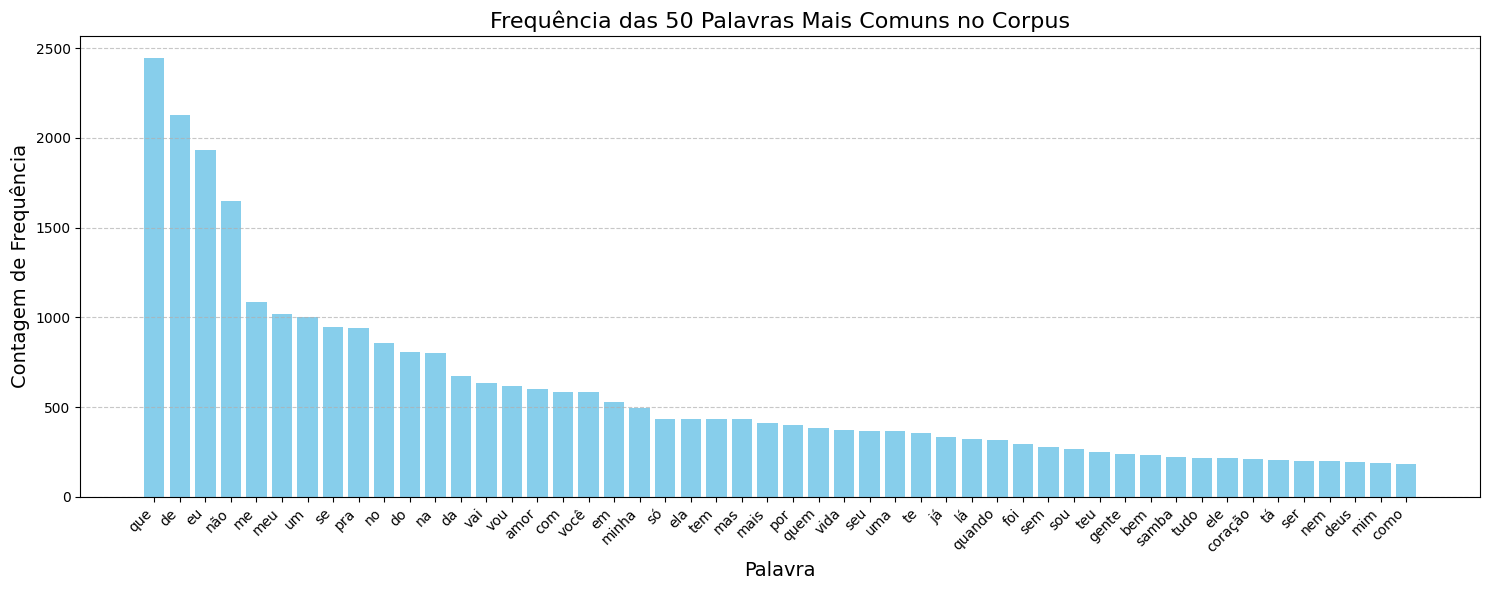

In [8]:
#Celula para visualização de grafico

import matplotlib.pyplot as plt

NUM_PALAVRAS_VIS = 50
comum_word = total_palavras.most_common(NUM_PALAVRAS_VIS)
nomes = [item[0] for item in comum_word]
frequencia = [item[1] for item in comum_word]

plt.figure(figsize=(15,6))
barras = plt.bar(nomes,frequencia,color='skyblue')

plt.title(f'Frequência das {NUM_PALAVRAS_VIS} Palavras Mais Comuns no Corpus', fontsize=16)
plt.xlabel('Palavra', fontsize=14)
plt.ylabel('Contagem de Frequência', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
#4ª - Conversao pra tensores e divisao (Train/Val/Test)

#vetor -> tensores longos de PyTorch
entrada_tensor = torch.LongTensor(entrada)
prevista_tensor = torch.LongTensor(prevista)

#Calcula os índices para a divisão (80/10/10)
tamanho = []
tamanho = preparacao_dados_tamanho(entrada)

#Divisao do Tensor de ENTRADA
entrada_treino = entrada_tensor[:tamanho[0]]
entrada_val = entrada_tensor[tamanho[0]:tamanho[1]]
entrada_test = entrada_tensor[tamanho[1]:]

#Divisão do Tensor de SAIDA/ROTULO
prevista_treino = prevista_tensor[:tamanho[0]]
prevista_val = prevista_tensor[tamanho[0]:tamanho[1]]
prevista_test = prevista_tensor[tamanho[1]:]

#info Tensor:
print(f"Tamanho do Conjunto de Treino: {len(entrada_treino)}")
print(f"Tamanho do Conjunto de Validação: {len(entrada_val)}")
print(f"Tamanho do Conjunto de Teste: {len(entrada_test)}")

Tamanho do Conjunto de Treino: 58916
Tamanho do Conjunto de Validação: 7364
Tamanho do Conjunto de Teste: 7366


In [10]:
#5ª - Criação dos Dataloaders
'''     Tensores estáticos sao transformados em interáveis que fornecem dados em "batches" para o device
            - [suffle = True]: aleatoriza os dados de treino em cada época.
'''

dataloader_treino = DataLoader(TextoDataset(entrada_treino, prevista_treino), batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(TextoDataset(entrada_val, prevista_val), batch_size=BATCH_SIZE)
dataloader_teste = DataLoader(TextoDataset(entrada_test, prevista_test), batch_size=BATCH_SIZE)

#6ª - Iniciação do Modelo e Componentes de treinamento

#Modelo gerador -> com arquitetura Bidirecional
mod_baseline = GeradorTextoLSTM(vocab_size=VOCAB_SIZE,embedding_dim=EMBEDDING_DIM,hidden_dim=HIDDEN_DIM,num_layers=NUM_LAYERS); mod_baseline.to(device)

#Config do treinamento
criterio = nn.CrossEntropyLoss()
otimizador = torch.optim.Adam(mod_baseline.parameters(), lr=LEARNING_RATE)

# 7ª - Execucao do treinamento!!!
historia_tre, historia_val= treinar_modelo(mod_baseline,dataloader_treino,dataloader_val,criterio,otimizador,NUM_EPOCHS)


Iniciando treinamento do Baseline! 
Época 1/10 
| Loss Treino: 6.6544 
| Loss Val: 6.7556
>>> Modelo salvo (Melhor Loss de Validação) <<<
Época 2/10 
| Loss Treino: 5.6659 
| Loss Val: 6.6600
>>> Modelo salvo (Melhor Loss de Validação) <<<
Época 3/10 
| Loss Treino: 4.7810 
| Loss Val: 6.6961
Época 4/10 
| Loss Treino: 4.0761 
| Loss Val: 6.7203
Época 5/10 
| Loss Treino: 3.5173 
| Loss Val: 6.7994
Época 6/10 
| Loss Treino: 3.0584 
| Loss Val: 6.9034
Época 7/10 
| Loss Treino: 2.6707 
| Loss Val: 6.9700
Época 8/10 
| Loss Treino: 2.3445 
| Loss Val: 7.0367
Época 9/10 
| Loss Treino: 2.0570 
| Loss Val: 7.2114
Época 10/10 
| Loss Treino: 1.8021 
| Loss Val: 7.3026


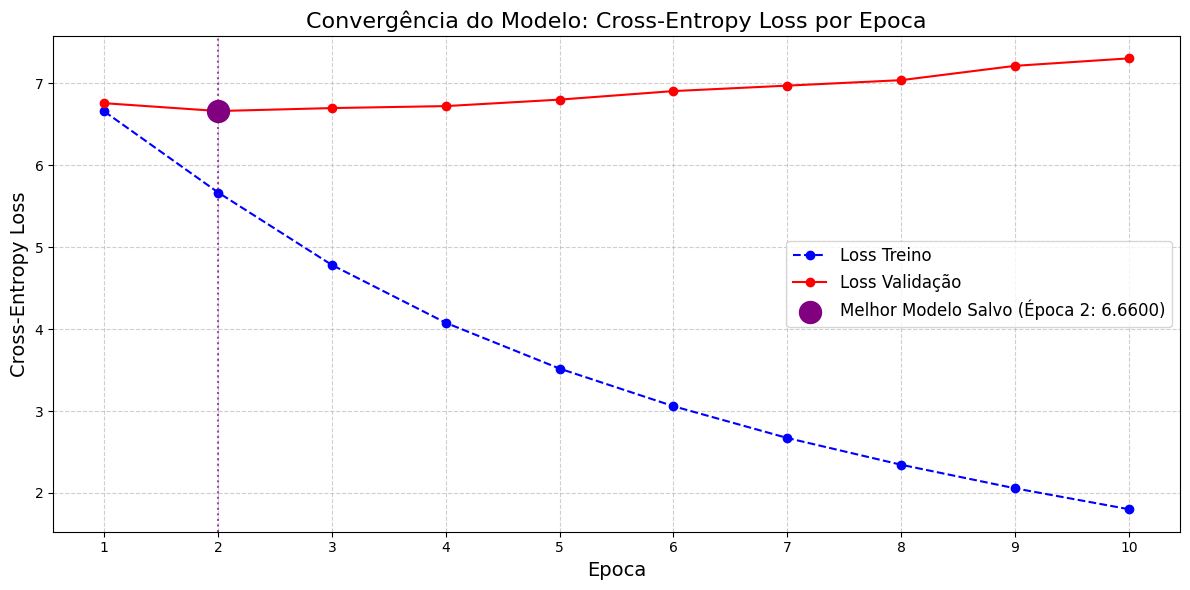

In [11]:
#Celula para visualização de grafico

ep = np.arange(1, len(historia_tre) + 1)
melhor_loss = np.min(historia_val)
melhor_ep = np.argmin(historia_val) +1
plt.figure(figsize=(12, 6))

plt.plot(ep, historia_tre, label='Loss Treino', marker='o', color='blue', linestyle='--')
plt.plot(ep, historia_val, label='Loss Validação', marker='o', color='red')
plt.scatter(melhor_ep,melhor_loss,color='purple',s=250,label=f'Melhor Modelo Salvo (Época {melhor_ep}: {melhor_loss:.4f})', zorder=5)
plt.axvline(x=melhor_ep, color='purple', linestyle=':', linewidth=1.5, alpha=0.7)
plt.title('Convergência do Modelo: Cross-Entropy Loss por Epoca', fontsize=16)
plt.xlabel('Epoca', fontsize=14)
plt.ylabel('Cross-Entropy Loss', fontsize=14)

plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(ep)
plt.tight_layout()
plt.show()

#Avaliação e Análise

Avaliação qualitativa e quantitativa do modelo treinado:

1. Cálculo da Perplexidade (PPL): Métrica quantitativa para medir a performance do modelo no conjunto de teste.

2. Geração de Amostras de Texto: Análise qualitativa da coerência e criatividade do texto gerado.

3. Análise Crítica: Discussão sobre erros, vieses e limitações observados.

###Avaliação do Modelo Base (modelo_baseline_melhor.pth)

1.1 Cálculo da Perplexidade (PPL)

In [12]:
# Função de avaliação

def calculo_ppl(modelo, dataloader, device):
  """
  Calculo da Perplexidade (PPL) de um modelo em um dataloader.
  """
  modelo.eval() # modelo em modo de avaliação
  criterio = nn.CrossEntropyLoss()
  total_loss = 0
  total_tokens = 0

  with torch.no_grad():
    # Iteração sobre cada batch de dados fornecido pelo dataloader
    for entradas, rotulos in dataloader:
      entradas, rotulos = entradas.to(device), rotulos.to(device) # move para GPU

      saidas, _ = modelo(entradas) # _ ignora estado da LSTM
      loss = criterio(saidas, rotulos) # calculo do erro

      total_loss += loss.item() * rotulos.size(0) # multiplica pq crossentropyloss retorna a média
      total_tokens += rotulos.size(0)

  # Calculo da perplexidade (PPL)
  loss_media = total_loss / total_tokens
  ppl = math.exp(loss_media)

  return ppl

In [16]:
#8ª - Carregamento do modelo salvo

    #Instancia o modelo na arquitetura final (Bidirecional)
mod = GeradorTextoLSTM(vocab_size= VOCAB_SIZE,embedding_dim= EMBEDDING_DIM,hidden_dim= HIDDEN_DIM,num_layers= NUM_LAYERS); mod.to(device)
    #Carrega os pesos do modelo com melhor Loss de Validação
mod.load_state_dict(torch.load(MODELO, map_location=device))
mod.to(device)

# calculo da PPL usando o dataloader_test
ppl_baseline = calculo_ppl(mod, dataloader_teste, device)

print("Resultado da Avaliação Quantitativa do Modelo Base:")
print(f"Perplexidade (PPL): {ppl_baseline:.4f}")

Resultado da Avaliação Quantitativa do Modelo Base:
Perplexidade (PPL): 654.4384


1.2 Geração de Amostras de Texto

* Temperatura 0.7: texto mais coerente
* Temperatura 1.0: texto mais equilibrado
* Temperatura 1.3: texto mais criativo

In [17]:
#8ª - Geração de texto

    #Pede ao usuario para entrar com uma 'semente inicial' para a geracao da letra.
start_seed = input("Insira o começo da musica: ")
num_to_gerador = 80
print("\n=== INICIANDO GERAÇÃO (Avaliação Qualitativa) ===\n")
print("-"*55)

    #Geracao 1: T=0.7 -> Prioriza palavras mais provaveis, ou seja, teoricamente prioriza uma maior coerencia no txt gerado
temp_7 = gerar_texto(mod, start_seed, num_to_gerador, 0.7, word_to_id, id_to_word, SEQ_LENGTH)
print(f"\n[Temperatura = 0.7] (Coerência):\n{temp_7}")

    #Geracao 2: T=1.0 -> Uma amostragem padrao, representa o equilibrio entre a coerencia e a 'criatividade'
temp_10 = gerar_texto(mod, start_seed, num_to_gerador, 1.0, word_to_id, id_to_word, SEQ_LENGTH)
print(f"\n[Temperatura = 1.0] (Padrão):\n{temp_10}")

    #Geracao 3: T=1.3 -> Suaviza probabilidades, ou seja, acaba por ter um grande aumento em 'criatividade', pode-se entender como uma geracao com teor mais aleatorio.
temp_13 = gerar_texto(mod, start_seed, num_to_gerador, 1.3, word_to_id, id_to_word, SEQ_LENGTH)
print(f"\n[Temperatura = 1.3] (Criatividade):\n{temp_13}")

Insira o começo da musica: amor é fogo que queima

=== INICIANDO GERAÇÃO (Avaliação Qualitativa) ===

-------------------------------------------------------

[Temperatura = 0.7] (Coerência):
amor é fogo que queima demais um fundo como <unk> da pra vida pois fazer moro qual <unk> por eu não posso sem <unk> <unk> com família <unk> que alô com samba <unk> que eu <unk> <unk> com as <unk> <unk> da <unk> não <unk> <unk> se <unk> de <unk> minha sinto por para você isso um dia vem por jura não por me fama foi seu um amor só tem um jeito mais um amor pode faltar meu amor em amor em meu coração

[Temperatura = 1.0] (Padrão):
amor é fogo que queima que paixão bote chorando <unk> menino contra <unk> por despedida do meio hoje contar dá meu curar com amou gente nega <unk> do um amor está só samba você pronto foram romper ver de foste por pelo nos os você luz de beleza as vou será que bemestar eu reservaram não tira bis do teu subiu por clarear tive eu de feitiço te sou você me jogou luz meu coraçã

'''
    Entede-se que sem o uso de embeddings pré-treinadas o resultado podem parecer aleatorios, sem sentidos, o que para nós humanos é completamente entendivel.
    Entretanto, mesmo utilizando de um corpus pequeno [441 musicas não são o suficiente para um resultado mais agradavel] o resultado é interessante...

    Agora veremos a mudança que o uso de embeddings pré-treinadas afeta no resultado!
'''